## Import modules

In [174]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import yfinance as yf
import backtrader as bt

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import sys
import arrow, datetime
import re
import math

In [175]:
print(f'python version: \t\t{sys.version}')
print(f'yfinance version: \t\t{yf.__version__}')
print(f'backtrader version: \t\t{bt.__version__}')
print(f'pandas version: \t\t{pd.__version__}')
print(f'numpy version: \t\t\t{np.__version__}')
print(f'matplotlib version: \t\t{matplotlib.__version__}')
print(f'arrow version: \t\t\t{arrow.__version__}')

python version: 		3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
yfinance version: 		0.2.35
backtrader version: 		1.9.78.123
pandas version: 		2.1.4
numpy version: 			1.26.3
matplotlib version: 		3.8.2
arrow version: 			1.3.0


<br>

## Global Variables

In [176]:
STOCK_NAMES = ['0050.TW', '0056.TW']
START_DATE = '2019-01-01'
END_DATE = '2024-01-01'
PERIOD = '1d'

<br>

## Strategy

In [177]:
# Only deposit and buy stocks monthly, never sell
class myStrategy(bt.Strategy):
    def log(self, txt = None):
        date = self.data.datetime.date(0)
        print(f'{str(txt)} \t {date.year}-{date.month}-{date.day}')

    def __init__(self):
        start_date = arrow.get(START_DATE)
        if start_date.day > 5:
            self._monthly_buy_date = arrow.Arrow(start_date.year, start_date.month + 1, 10)
            self._monthly_deposit_date = arrow.Arrow(start_date.year, start_date.month + 1, 5)
        else:
            self._monthly_buy_date = arrow.Arrow(start_date.year, start_date.month, 10)
            self._monthly_deposit_date = arrow.Arrow(start_date.year, start_date.month, 5)

    def next(self):
        single_stock_budget = self.broker.get_cash() / (len(self.datas) + 1)
        
        if self._monthly_buy_date.datetime.date() <= self.data.datetime.date(0):
            self._monthly_buy_date = self._monthly_buy_date.shift(months = 1)
            for data in self.datas:
                self.buy(data = data, price = data.open[0], size = math.floor(single_stock_budget / data.open[0]))
                self.log(f'[Monthly Buy] {data._name} {data.open[0] * math.floor(single_stock_budget / data.open[0])}')
            print('=' * 30)
            
        if self._monthly_deposit_date.datetime.date() <= self.data.datetime.date(0):
            self._monthly_deposit_date = self._monthly_deposit_date.shift(months = 1) 
            self.broker.add_cash(2000)
            self.log(f'[Monthly Deposit] {self.broker.get_cash()}')
            print('=' * 30)

In [178]:
# Deposit and buy stocks monthly
# Use short term sma and long term sma to decide when to buy and sell
class myStrategy_ver2(bt.Strategy):
    def log(self, txt = None):
        date = self.data.datetime.date(0)
        print(f'{str(txt)} \t {date.year}-{date.month}-{date.day}')

    def __init__(self):
        start_date = arrow.get(START_DATE)
        if start_date.day > 5:
            self._monthly_buy_date = arrow.Arrow(start_date.year, start_date.month + 1, 10)
            self._monthly_deposit_date = arrow.Arrow(start_date.year, start_date.month + 1, 5)
        else:
            self._monthly_buy_date = arrow.Arrow(start_date.year, start_date.month, 10)
            self._monthly_deposit_date = arrow.Arrow(start_date.year, start_date.month, 5)

        self.crossover = [[] for i in range(len(self.datas))]
        for i in range(len(self.datas)):
            sma10 = bt.indicators.SimpleMovingAverage(self.datas[i], period = 10)
            sma60 = bt.indicators.SimpleMovingAverage(self.datas[i], period = 60)
            self.crossover[i] = bt.indicators.CrossOver(sma10, sma60)

        # We need to wait for 30 days to get the first long term sma
        self._next_operation_date = [[] for i in range(len(self.datas))]
        for i in range(len(self.datas)):
            self._next_operation_date[i] = start_date.shift(days = 60)

    def next(self):
        single_stock_budget = self.broker.get_cash() / (len(self.datas) + 1)
        
        if self._monthly_buy_date.datetime.date() <= self.data.datetime.date(0):
            self._monthly_buy_date = self._monthly_buy_date.shift(months = 1)
            for i, data in enumerate(self.datas):
                self.buy(data = data, price = data.open[0], size = math.floor(single_stock_budget / data.open[0]))
                self.log(f'[Monthly Buy] {data._name} {data.open[0] * math.floor(single_stock_budget / data.open[0])}')
            print('=' * 30)
            
        if self._monthly_deposit_date.datetime.date() <= self.data.datetime.date(0):
            self._monthly_deposit_date = self._monthly_deposit_date.shift(months = 1) 
            self.broker.add_cash(2000)
            self.log(f'[Monthly Deposit] {self.broker.get_cash()}')
            print('=' * 30)

        single_stock_budget = self.broker.get_cash() / (len(self.datas) + 1)
        for i, data in enumerate(self.datas):
            if self._next_operation_date[i].datetime.date() > self.data.datetime.date(0):
                continue

            if self.crossover[i] > 0:
                self.buy(data = data, price = data.open[0], size = math.floor(single_stock_budget / data.open[0]))
                self.log(f'[Buy] {data._name} {data.open[0] * math.floor(single_stock_budget / data.open[0])}')
                self._next_operation_date[i] = arrow.get(self.data.datetime.date(0)).shift(days = 3)
            elif self.crossover[i] < 0:
                self.sell(data = data, price = data.open[0], size = self.getposition(data).size / 2)
                self.log(f'[Sell] {data._name} {data.open[0] * self.getposition(data).size / 2}')
                self._next_operation_date[i] = arrow.get(self.data.datetime.date(0)).shift(days = 3)

In [179]:
# Deposit monthly
# Buy and sell depending on the bollinger bands and k line
class myStrategy_ver3(bt.Strategy):
    def log(self, txt = None):
        date = self.data.datetime.date(0)
        print(f'{str(txt)} \t {date.year}-{date.month}-{date.day}')

    def __init__(self):
        start_date = arrow.get(START_DATE)
        if start_date.day > 5:
            self._monthly_buy_date = arrow.Arrow(start_date.year, start_date.month + 1, 10)
            self._monthly_deposit_date = arrow.Arrow(start_date.year, start_date.month + 1, 5)
        else:
            self._monthly_buy_date = arrow.Arrow(start_date.year, start_date.month, 10)
            self._monthly_deposit_date = arrow.Arrow(start_date.year, start_date.month, 5)

        self._bollinger = [[] for i in range(len(self.datas))]
        for i in range(len(self.datas)):
            self._bollinger[i] = bt.indicators.BollingerBands(self.datas[i], period = 20, devfactor = 2)

        self._next_operation_date = [[] for i in range(len(self.datas))]
        for i in range(len(self.datas)):
            self._next_operation_date[i] = start_date.shift(days = 20)

    def next(self):
        if self._monthly_deposit_date.datetime.date() <= self.data.datetime.date(0):
            self._monthly_deposit_date = self._monthly_deposit_date.shift(months = 1) 
            self.broker.add_cash(2000)
            self.log(f'[Monthly Deposit] {self.broker.get_cash()}')
            print('=' * 30)
        
        single_stock_budget = self.broker.get_cash() / (len(self.datas) + 1)
        for i, data in enumerate(self.datas):
            if self._next_operation_date[i].datetime.date() > self.data.datetime.date(0):
                continue

            signal = self.signal(data, self._bollinger[i])
            if signal > 0:
                self.buy(data = data, price = data.open[0], size = math.floor((single_stock_budget / data.open[0]) * (signal / 3)))
                self.log(f'[Buy] {data._name} {data.open[0] * math.floor((single_stock_budget / data.open[0]) * (signal / 3))}')
                self._next_operation_date[i] = arrow.get(self.data.datetime.date(0)).shift(days = 10)
            elif signal < 0:
                self.sell(data = data, price = data.open[0], size = self.getposition(data).size * -signal / 3)
                self.log(f'[Sell] {data._name} {data.open[0] * self.getposition(data).size * -signal / 2}')
                self._next_operation_date[i] = arrow.get(self.data.datetime.date(0)).shift(days = 10)

    def signal(self, data, bollinger):
        percent_b_4days_ago = (data.close[-4] - bollinger.lines.bot[-4]) / (bollinger.lines.top[-4] - bollinger.lines.bot[-4])
        percent_b_yesterday = (data.close[-1] - bollinger.lines.bot[-1]) / (bollinger.lines.top[-1] - bollinger.lines.bot[-1])

        # K line pierce upward the lower band
        if percent_b_4days_ago < 0 and percent_b_yesterday > 0:
            return 1

        # K line pierce upward the middle band
        if percent_b_4days_ago < 0.5 and percent_b_yesterday > 0.5:
            return 2
        
        # K line keep ascending 
        if percent_b_yesterday > percent_b_4days_ago > 0.5:
            return 3
        
        # K line pierce downward the middle band
        if percent_b_4days_ago > 0.5 > percent_b_yesterday:
            return -1
        
        # K line is between the middle band and the lower band, and keep descending
        if 0.5 > percent_b_4days_ago > percent_b_yesterday > 0:
            return -2
        
        return 0

<br>

## Backtest

Initial capital: 10000


[Monthly Deposit] 10000.0 	 2019-1-7
[Monthly Buy] 0050.TW 3964.400161743164 	 2019-1-10
[Monthly Buy] 0056.TW 3992.299873352051 	 2019-1-10
[Monthly Buy] 0050.TW 1280.9499740600586 	 2019-2-11
[Monthly Buy] 0056.TW 1329.239995956421 	 2019-2-11
[Monthly Deposit] 4013.4798889160156 	 2019-2-11
[Monthly Deposit] 3407.529914855957 	 2019-3-5
[Monthly Buy] 0050.TW 1744.5499649047852 	 2019-3-11
[Monthly Buy] 0056.TW 1782.9600105285645 	 2019-3-11
[Monthly Deposit] 1844.5999183654785 	 2019-4-8
[Monthly Buy] 0050.TW 1216.4999771118164 	 2019-4-10
[Monthly Buy] 0056.TW 1269.0 	 2019-4-10
[Monthly Deposit] 1355.349941253662 	 2019-5-6
[Monthly Buy] 0050.TW 1060.1500396728516 	 2019-5-10
[Monthly Buy] 0056.TW 1096.3399906158447 	 2019-5-10
[Monthly Deposit] 1213.319932937622 	 2019-6-5
[Monthly Buy] 0050.TW 1022.4500198364258 	 2019-6-10
[Monthly Buy] 0056.TW 1061.8999843597412 	 2019-6-10
[Monthly Deposit] 1114.4399757385254 	 2019-7-5
[Monthly Buy] 0050.TW 983.3999633789062 	 2019-7-10
[Mon

<IPython.core.display.Javascript object>

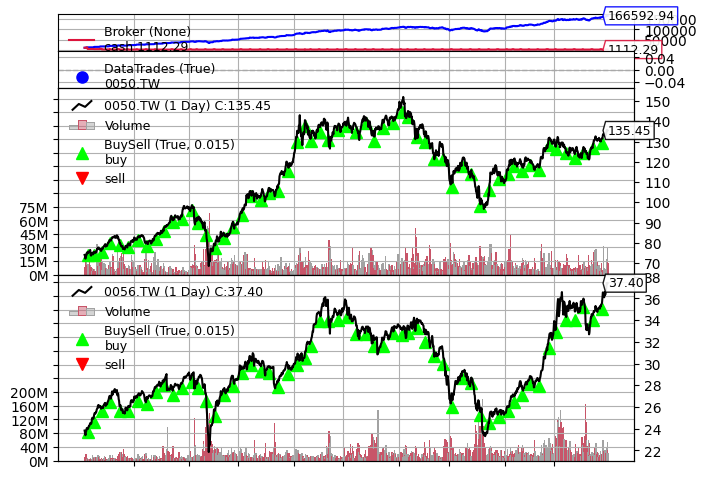

In [180]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(10_000)
print(f'Initial capital: {cerebro.broker.getvalue()}')

for name in STOCK_NAMES:
    stock_data = bt.feeds.PandasData(dataname = yf.download(
        name, 
        start = START_DATE, 
        end = END_DATE, 
        interval = PERIOD,
        progress = False
    ))
    cerebro.adddata(stock_data, name = name)

cerebro.addstrategy(myStrategy)
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name = 'annual_return')
result = cerebro.run()

print(f'Annual return: {result[0].analyzers.annual_return.get_analysis()}')

%matplotlib inline
print(f'Final capital: {cerebro.broker.getvalue()}')
cerebro.plot(iplot = True, plotylimit = True, plotforce = True)[0][0]

Initial capital: 10000
[Monthly Buy] 0050.TW 3253.9999389648438 	 2019-4-11
[Monthly Buy] 0056.TW 3321.0 	 2019-4-11
[Monthly Deposit] 10000.0 	 2019-4-11
[Monthly Buy] 0050.TW 1785.300033569336 	 2019-4-12
[Monthly Buy] 0056.TW 1801.6299591064453 	 2019-4-12
[Monthly Deposit] 5446.530014038086 	 2019-4-12
[Monthly Buy] 0050.TW 1224.7500228881836 	 2019-4-15
[Monthly Buy] 0056.TW 1263.8299713134766 	 2019-4-15
[Monthly Deposit] 3848.6000213623047 	 2019-4-15
[Monthly Buy] 0050.TW 1064.0499801635742 	 2019-4-16
[Monthly Buy] 0056.TW 1107.8200187683105 	 2019-4-16
[Monthly Deposit] 3350.9100227355957 	 2019-4-16
[Monthly Deposit] 3162.9399642944336 	 2019-5-6
[Monthly Buy] 0050.TW 1712.550064086914 	 2019-5-10
[Monthly Buy] 0056.TW 1711.3599853515625 	 2019-5-10
[Sell] 0056.TW 4449.420078277588 	 2019-5-17
[Sell] 0050.TW 4340.099830627441 	 2019-5-22
[Monthly Deposit] 10501.234893798828 	 2019-6-5
[Monthly Buy] 0050.TW 4089.800079345703 	 2019-6-10
[Monthly Buy] 0056.TW 4143.999938964844

<IPython.core.display.Javascript object>

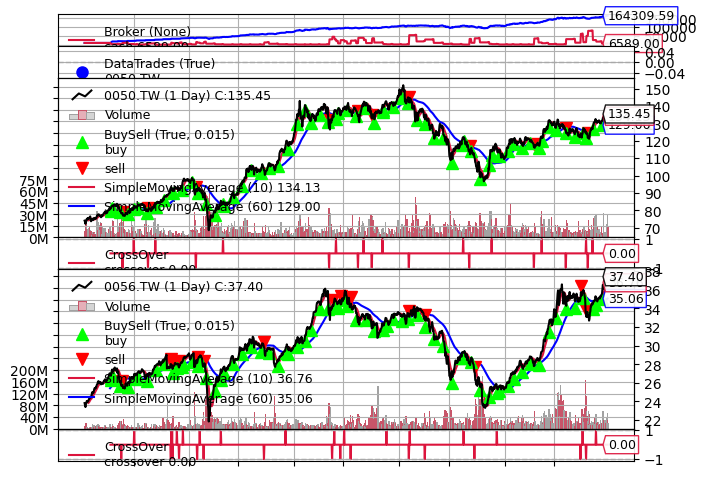

In [181]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(10_000)
print(f'Initial capital: {cerebro.broker.getvalue()}')

for name in STOCK_NAMES:
    stock_data = bt.feeds.PandasData(dataname = yf.download(
        name, 
        start = START_DATE, 
        end = END_DATE, 
        interval = PERIOD,
        progress = False
    ))
    cerebro.adddata(stock_data, name = name)

cerebro.addstrategy(myStrategy_ver2)
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name = 'annual_return')
result = cerebro.run()

print(f'Annual return: {result[0].analyzers.annual_return.get_analysis()}')

%matplotlib inline
print(f'Final capital: {cerebro.broker.getvalue()}')
cerebro.plot(iplot = True, plotylimit = True, plotforce = True)[0][0]

Initial capital: 10000
[Monthly Deposit] 10000.0 	 2019-1-29
[Monthly Deposit] 12000.0 	 2019-2-11
[Buy] 0050.TW 3037.9998779296875 	 2019-2-13
[Buy] 0056.TW 4655.199859619141 	 2019-2-13
[Buy] 0050.TW 2088.4499588012695 	 2019-2-25
[Buy] 0056.TW 2100.3300247192383 	 2019-2-25
[Monthly Deposit] 2084.7799015045166 	 2019-3-5
[Sell] 0050.TW 2540.9749488830566 	 2019-3-11
[Buy] 0056.TW 1923.2599830627441 	 2019-3-14
[Buy] 0050.TW 1260.800048828125 	 2019-3-21
[Buy] 0056.TW 865.9199924468994 	 2019-3-25
[Buy] 0050.TW 560.0 	 2019-4-1
[Monthly Deposit] 1184.4765485127764 	 2019-4-8
[Buy] 0056.TW 376.1800117492676 	 2019-4-8
[Buy] 0050.TW 894.849983215332 	 2019-4-11
[Buy] 0056.TW 631.1200122833252 	 2019-4-18
[Buy] 0050.TW 414.00001525878906 	 2019-4-26
[Monthly Deposit] 874.7765286763506 	 2019-5-6
[Buy] 0050.TW 247.79999542236328 	 2019-5-6
[Buy] 0056.TW 274.6999931335449 	 2019-5-6
[Buy] 0056.TW 261.5999984741211 	 2019-5-16
[Buy] 0050.TW 156.0 	 2019-5-21
[Monthly Deposit] 1939.42652638

<IPython.core.display.Javascript object>

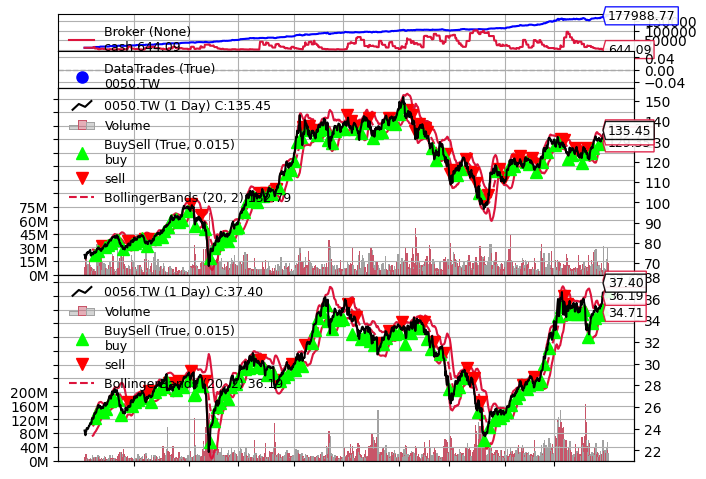

In [182]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(10_000)
print(f'Initial capital: {cerebro.broker.getvalue()}')

for name in STOCK_NAMES:
    stock_data = bt.feeds.PandasData(dataname = yf.download(
        name, 
        start = START_DATE, 
        end = END_DATE, 
        interval = PERIOD,
        progress = False
    ))
    cerebro.adddata(stock_data, name = name)

cerebro.addstrategy(myStrategy_ver3)
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name = 'annual_return')
result = cerebro.run()

print(f'Annual return: {result[0].analyzers.annual_return.get_analysis()}')

%matplotlib inline
print(f'Final capital: {cerebro.broker.getvalue()}')
cerebro.plot(iplot = True, plotylimit = True, plotforce = True)[0][0]